# EXPLORED EDA - TIME SERIES

In [2]:
# -------------------------------
# IMPORTS
# -------------------------------

# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Decompose time-series in 3 components: trend, seasonal and resid
from statsmodels.tsa.seasonal import seasonal_decompose
# To evaluate the seasonality of the time series we can apply the so-called Dickey-Fuller test
# It is a hypothesis test in which the null hypothesis is that the series is stationary
# The alternative, that it is non-stationary:
from statsmodels.tsa.stattools import adfuller
# Autocorrelation is the correlation of a time series with a lagged copy of itself.
# This graph helps us see if the values ​​in the time series are correlated with previous values.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Automate the selection of the best parameters for an ARIMA model, saving time compared to manual tuning.
from pmdarima import auto_arima

In [3]:
def log(message: str, level: int = 1, type: str = "INFO", custom_icon: str = None, bold: bool = False):
    # Default icons according to message type
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
    }

    # Use custom icon if provided
    if custom_icon:
        icon = custom_icon
    else:
        icon = icons.get(type.upper(), "ℹ️")

    # Bold wrapper (ANSI)
    if bold:
        message = f"\033[1m{message}\033[0m"

    # First level → bullet
    if level == 1:
        prefix = "•"
    # Second level → indent + hyphen
    elif level == 2:
        prefix = "   -"
    # Level 3 → deeper indent + middle dot
    elif level == 3:
        prefix = "      ·"
    # Fallback
    else:
        prefix = "-"
    
    # Final print
    print(f"{prefix} {icon} {message}")

## STEP 0 - LOAD RAW DATAFRAME

In [4]:
# Raw dataset formatting
data_separator = ","
input_path = "../data/raw/internal-link.csv"
# Thresholds for dataset type proposal (NLP)
min_text_avg_length = 25      # Recommended: 20–30 chars → typical minimum for real text
min_text_avg_words  = 3       # Recommended: >3 words → avoids titles/labels
# Thresholds for dataset type proposal (Time-Series)
min_rows_in_dataset = 75      # Recommended: > 75
max_numeric_var = 5           # More than 5 is odd for a time-series
freq_ratio_threshold = 0.7    # Recommended: > 0.7 (values from 0 to 1)


In [18]:
print("STEP 0) LOAD RAW DATAFRAME")

# Load raw DataFrame
df_raw = pd.read_csv(input_path, sep=data_separator)
log("DataFrame loaded successfully!", type="SUCCESS")

# ---------------------------------------------------------
# NLP CHECKING (probabilistic)
# ---------------------------------------------------------
log("NLP cheking:", custom_icon="📝")
nlp_score = 0            # Final probability score (0–100)
nlp_diag = []            # Diagnostic report

# Evidence 1: dataset has at least one text-like column
object_cols = []
for col in df_raw.columns:
    if df_raw[col].dtype in ["object", "category"]:
        object_cols.append(col)
if len(object_cols) >= 1:
    nlp_score += 25
    log(f"Object-type columns found: {object_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No object-type columns found", level=2, type="ERROR")

# Evidence 2: long text columns exist
text_cols = []
for col in object_cols:
    avg_len = df_raw[col].dropna().str.len().mean()
    if avg_len is not None and avg_len > min_text_avg_length:
        text_cols.append(col)
if len(text_cols) >= 1:
    nlp_score += 25
    log(f"Long text-like columns found: {text_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 3: rich text structure (words per entry)
rich_text_cols = []
for col in text_cols:
    avg_words = df_raw[col].dropna().str.split().str.len().mean()
    if avg_words is not None and avg_words > min_text_avg_words:
        rich_text_cols.append(col)
if len(rich_text_cols) > 0:
    nlp_score += 25
    log(f"At least one column shows word-rich entries -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No column shows word-rich entries", level=2, type="ERROR")

# Evidence 4: number of text columns realistic for NLP
if len(text_cols) == 1:
    nlp_score += 15
    log(f"There is only 1 long text-like column, it is typical for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
elif len(text_cols) > 1:
    nlp_score += 5
    log(f"There are more than 1 long text-like column, it could be possible for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 5: proportion of non-empty text entries
if len(text_cols) >= 1:
    non_empty_ratio = df_raw[text_cols[0]].dropna().str.len().gt(10).mean()
    if non_empty_ratio >= 0.6:
        nlp_score += 10
        log(f"Majority of rows contain meaningful text -> + {nlp_score}%", level=2, type="SUCCESS")
    else:
        log("Too many empty/short text entries", level=2, type="ERROR")

# Cap score at 100
nlp_score = min(nlp_score, 100)
log(f"Probability score to be a NLP Dataset: {nlp_score}%", level=2, type="INFO")

# ---------------------------------------------------------
# TIME-SERIES CHECKING (probabilistic)
# ---------------------------------------------------------
log("TIME-SERIES checking:", custom_icon="⏱️")
ts_score = 0                  # Final probability score (0–100)
ts_cols = []                  # List of detected datetime columns
ts_main_col = None            # Main datetime column chosen
ts_diag = []                  # Diagnostic list

# ---------------------------------------------------------
# Evidence 1) Detect datetime columns (robust)
# ---------------------------------------------------------
# Try to parse every column → if successful → datetime candidate
for col in df_raw.columns:
    try:
        pd.to_datetime(df_raw[col], errors="raise")
        ts_cols.append(col)
    except:
        pass

# Case 1 → no datetime columns
if len(ts_cols) == 0:
    log("No datetime columns detected", level=2, type="ERROR")
# Case 2 → exactly one column
elif len(ts_cols) == 1:
    ts_score += 40
    ts_main_col = ts_cols[0]
    log(f"Unique datetime column detected: {ts_main_col} -> + {ts_score}%", level=2, type="SUCCESS")
# Case 3 → multiple datetime columns
elif len(ts_cols) > 1:
    ts_score += 25
    ts_main_col = ts_cols[0]
    log(f"Several datetime columns were detected: {ts_cols} -> + {ts_score}%", level=2, type="SUCCESS")
    # Check if all datetime columns share similar structure
    for col in ts_cols:
        try:
            dt_tmp = pd.to_datetime(df_raw[col], errors="coerce")
            missing_rate = dt_tmp.isna().mean()
            log(f"Column '{col}' parsed with missing rate: {missing_rate:.3f}", level=3, type="INFO")
        except:
            log(f"Column '{col}' failed advanced parsing", level=3, type="ERROR")

if ts_main_col is not None: # Evaluate time-series structure (only if datetime column exists)

    # Convert chosen datetime column
    serie_date_time_raw = pd.to_datetime(df_raw[ts_main_col], errors="coerce")

    # ---------------------------------------------------------
    # Evidence 2) Chronologically sorted
    # ---------------------------------------------------------
    if serie_date_time_raw.is_monotonic_increasing:
        ts_score += 20
        log(f"Datetime column '{ts_main_col}' is sorted -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log(f"Datetime column '{ts_main_col}' is NOT sorted", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 3) Detecting time-series frequency
    # ---------------------------------------------------------
    serie_date_time_diff_raw = serie_date_time_raw.diff().dropna()

    if len(serie_date_time_diff_raw) > 0:
        # Compute most common interval
        most_common_delta = serie_date_time_diff_raw.mode()[0]
        freq_ratio = (serie_date_time_diff_raw == most_common_delta).mean()
        if freq_ratio >= freq_ratio_threshold:
            ts_score += 20
            log(f"Regular frequency detected -> + {ts_score}%", level=2, type="SUCCESS")
            log(f"Frequency consistency ratio: {freq_ratio:.3f}", level=3, type="INFO")
        else:
            log("No regular frequency detected", level=2, type="ERROR")
    else:
        log("Not enough data to detect time-series frequency", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 4) Numeric columns over time
    # ---------------------------------------------------------
    numeric_cols = df_raw.select_dtypes(include=["number"]).columns
    if 1 <= len(numeric_cols) <= max_numeric_var:
        ts_score += 10
        log(f"Numeric variables suitable for TS -> + {ts_score}%", level=2, type="SUCCESS")
    elif len(numeric_cols) < 1:
        log("There is not at least one numeric variable for time-series", level=2, type="ERROR")
    else:
        log("Too many numeric varaibles for time-series", level=2, type="ERROR")

    # ---------------------------------------------------------
    # Evidence 5) Dataset length
    # ---------------------------------------------------------
    if len(df_raw) >= min_rows_in_dataset:
        ts_score += 10
        log(f"Enough rows for time-series -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log("Dataset too short for time-series", level=2, type="ERROR")

# Cap score at 100
ts_score = min(ts_score, 100)

log(f"Probability score to be a TIME-SERIES Dataset: {ts_score}%", level=2, type="INFO")

# ---------------------------------------------------------
# Dataset type proposal
# ---------------------------------------------------------
if ts_score >= nlp_score and ts_score >= 75:
    dataset_type_auto = "TIME-SERIES"
elif nlp_score >= ts_score and nlp_score >= 75:
    dataset_type_auto = "NLP"
else:
    dataset_type_auto = "TABULAR"
print("----------------------------------------")
log(f"Proposed dataset type: {dataset_type_auto}", type="INFO", bold=True)
print("----------------------------------------")

STEP 0) LOAD RAW DATAFRAME
• ✅ DataFrame loaded successfully!
• 📝 NLP cheking:
   - ✅ Object-type columns found: ['date'] -> + 25%
   - ✅ Long text-like columns found: ['date'] -> + 50%
   - ❌ No column shows word-rich entries
   - ✅ There is only 1 long text-like column, it is typical for NLP -> + 65%
   - ✅ Majority of rows contain meaningful text -> + 75%
   - ℹ️ Probability score to be a NLP Dataset: 75%
• ⏱️ TIME-SERIES checking:
   - ✅ Several datetime columns were detected: ['date', 'sales'] -> + 25%
      · ℹ️ Column 'date' parsed with missing rate: 0.000
      · ℹ️ Column 'sales' parsed with missing rate: 0.000
   - ✅ Datetime column 'date' is sorted -> + 45%
   - ✅ Regular frequency detected -> + 65%
      · ℹ️ Frequency consistency ratio: 1.000
   - ✅ Numeric variables suitable for TS -> + 75%
   - ✅ Enough rows for time-series -> + 85%
   - ℹ️ Probability score to be a TIME-SERIES Dataset: 85%
----------------------------------------
• ℹ️ Proposed dataset type: TIME-SERIES


## STEP 1 - EXPLORE DATAFRAME

In [17]:
dataset_type = "TIME-SERIES" # Confirm dataset type (TIME-SERIES, NLP or TABULAR)
ts_main_col_index = 0 # Needed if TIME-SERIES is selected

In [20]:
# -------------------------------
# STEP 1) EXPLORE DATAFRAME
# -------------------------------
print("STEP 1) EXPLORE DATAFRAME")

# Copy original DataFrame
df_S1 = df_raw.copy()

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    log("Dataset detected as NLP (long-text dataset)", custom_icon="📝")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Sample of raw text entries:", type="INFO")
    display(df_S1[text_cols].head(5))

    # Print text length stats
    df_S1_lengths = df_S1[text_cols[0]].astype(str).str.len()
    log("Text length statistics:", type="INFO")
    log(f"Average lengths: {df_S1_lengths.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median lengths: {df_S1_lengths.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max lengths: {df_S1_lengths.max():.1f} chars", level=2, custom_icon="📊")

    # Compute word statistics
    df_S1_words = df_S1[text_cols[0]].astype(str).str.split().str.len()
    log("Word count statistics:", type="INFO")
    log(f"Average words: {df_S1_words.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median words: {df_S1_words.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max words: {df_S1_words.max():.1f} chars", level=2, custom_icon="📊")

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------
elif dataset_type == "TIME-SERIES":
    log("Dataset detected as TIME-SERIES", custom_icon="⏱️")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))

    # Try to parse every column
    df_S1_ts_cols = []
    for col in df_S1.columns:
        try:
            pd.to_datetime(df_S1[col], errors="raise")
            df_S1_ts_cols.append(col)
        except:
            pass

    # Time column
    df_S1_ts_main_col = df_S1_ts_cols[ts_main_col_index]
    serie_date_time_S1 = pd.to_datetime(df_S1[df_S1_ts_main_col], errors="coerce")
    log("Time index information:", type="INFO")
    log(f"Detected time column: '{df_S1_ts_main_col}'", level=2, custom_icon="📅")
    log(f"Start date: {serie_date_time_S1.min()}", level=2, custom_icon="📅")
    log(f"End date: {serie_date_time_S1.max()}", level=2, custom_icon="📅")
    log(f"Total duration: {serie_date_time_S1.max() - serie_date_time_S1.min()}", level=2, custom_icon="📅")

    # Estimate frequency and granularity
    serie_date_time_diff_S1 = serie_date_time_S1.diff().dropna()
    if len(serie_date_time_diff_S1) > 0:
        df_S1_most_common_delta = serie_date_time_diff_S1.mode()[0] # Most common interval
        df_S1_smallest_delta = serie_date_time_diff_S1.min() # Minimal interval
        df_S1_freq_ratio = (serie_date_time_diff_S1 == df_S1_most_common_delta).mean()
        # Determine granularity
        df_S1_seconds = df_S1_most_common_delta.total_seconds()
        if df_S1_seconds < 1:
            granularity = "sub-second"
        elif df_S1_seconds >= 1 and df_S1_seconds < 60:
            granularity = "second"
        elif df_S1_seconds >= 60 and df_S1_seconds < 3600:
            granularity = "minute"
        elif df_S1_seconds >= 3600 and df_S1_seconds < 86400:
            granularity = "hour"
        elif df_S1_seconds == 86400:
            granularity = "day"
        elif df_S1_seconds > 86400 and df_S1_seconds <= 86400 * 7:
            granularity = "multi-day"
        elif df_S1_seconds == 86400 * 7:
            granularity = "week"
        elif df_S1_seconds > 86400 * 7 and df_S1_seconds < 86400 * 28:
            granularity = "weekly-to-monthly"
        elif df_S1_seconds >= 86400 * 28 and df_S1_seconds <= 86400 * 31:
            granularity = "month"
        elif df_S1_seconds > 86400 * 31 and df_S1_seconds <= 86400 * 92:
            granularity = "quarter"
        else:
            granularity = "year-or-more"

        log(f"Most common interval: {df_S1_most_common_delta} (granularity: {granularity})", level=2, custom_icon="📅")
        log(f"Smallest interval: {df_S1_smallest_delta}", level=2, custom_icon="📅")
        log(f"Frequency consistency ratio: {df_S1_freq_ratio:.3f}", level=2, custom_icon="📅")
    else:
        log("Not enough data points to estimate frequency", type="WARNING")

    # Missing or irregular timestamps
    missing_ratio = 1 - (serie_date_time_diff_S1 == most_common_delta).mean() if len(serie_date_time_diff_S1) > 0 else None
    if missing_ratio is not None and missing_ratio > 0.10:
        log("Irregular timestamps detected (missing or uneven intervals)", type="WARNING")
        log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")

    # Numeric metrics
    numeric_cols = df_S1.select_dtypes(include=["number"]).columns
    log("Numeric metrics detected:", type="INFO")
    for col in numeric_cols:
        log(f"{col}", level=2, custom_icon="📈")

    # Statistics for each metric
    log("Basic statistics per numeric variable:", type="INFO")
    display(df_S1[numeric_cols].describe().T)

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    log("Dataset detected as TABULAR", custom_icon="🧮")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Info of the DataFrame (dataType and non-null values):", type="INFO")
    df_S1.info(verbose=True, show_counts=True)

    # Ordered info (fewest non-null first)
    ordered_info = pd.DataFrame({
        "Column": df_S1.columns,
        "Non-Null Count": df_S1.notnull().sum(),
        "Null Count": df_S1.isnull().sum(),
        "Dtype": df_S1.dtypes.astype(str)
    }).sort_values(by="Non-Null Count", ascending=True)
    log("Ordered info by number of non-null values:", type="INFO")
    display(ordered_info)

    # Count unique attributes (unsorted)
    df_S1_summary = pd.DataFrame({
        "Column": df_S1.columns,
        "Unique_Count": df_S1.nunique().values
    })
    log("DataFrame unique attributes (unsorted):", type="INFO")
    display(df_S1_summary)

    # Ordered summary (fewest unique first)
    df_S1_summary_ordered = df_S1_summary.sort_values(by="Unique_Count", ascending=True)
    log("Ordered unique attributes (fewest unique first):", type="INFO")
    display(df_S1_summary_ordered)

    # Automatic Warning for high-uniqueness columns
    unique_counts = df_S1.nunique()
    high_unique_cols = unique_counts[unique_counts == len(df_S1)].index.tolist()
    if len(high_unique_cols) > 0:
        log("Consider dropping the following columns for having UNIQUE values for EVERY row:", type="WARNING")
        for col in high_unique_cols:
            log(f"{col}", level=2, custom_icon="🗑️")

STEP 1) EXPLORE DATAFRAME
• ⏱️ Dataset detected as TIME-SERIES
• ℹ️ Shape of the DataFrame: (366, 2)
• ℹ️ Content of the DataFrame:


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


• ℹ️ Time index information:
   - 📅 Detected time column: 'date'
   - 📅 Start date: 2022-09-03 17:10:08.079328
   - 📅 End date: 2023-09-03 17:10:08.079328
   - 📅 Total duration: 365 days 00:00:00
   - 📅 Most common interval: 1 days 00:00:00 (granularity: day)
   - 📅 Smallest interval: 1 days 00:00:00
   - 📅 Frequency consistency ratio: 1.000
• ℹ️ Numeric metrics detected:
   - 📈 sales
• ℹ️ Basic statistics per numeric variable:


,count,mean,std,min,25%,50%,75%,max
sales,366.0,524.963968,275.089698,53.803211,290.186822,520.699468,763.289263,1000.482785


STEP 2) BUILD TIME INDEX
• 🔍 Detected temporal column: 'date'
• ℹ️ Indexed DataFrame by 'date'
• ℹ️ Preview of time-indexed DataFrame:


,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


• ✅ Extracted target time-series 'sales'


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

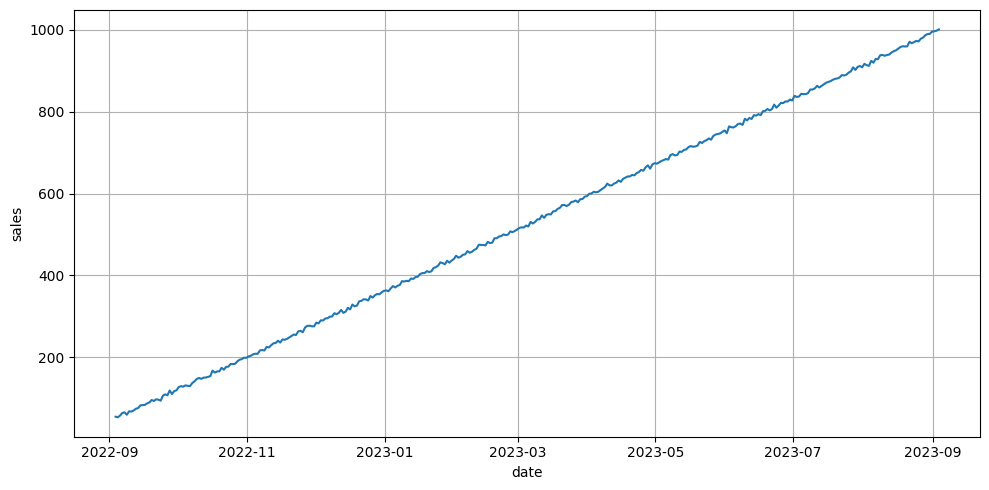

In [34]:
# -------------------------------
# STEP 2) BUILD TIME INDEX
# -------------------------------
print("STEP 2) BUILD TIME INDEX")

# Copy previous DataFrame
df_S2 = df_S1.copy()
df_S2_ts_main_col = df_S1_ts_main_col

if dataset_type == "TIME-SERIES":
    # Identify the temporal column
    if len(df_S2_ts_main_col) > 0:
        log(f"Detected temporal column: '{df_S2_ts_main_col}'", type="FOUND")
    else:
        log("No temporal column found → cannot build time index", type="ERROR")
        df_S2_ts_main_col = None
    # Stop if no datetime column exists
    if df_S2_ts_main_col is None:
        raise ValueError("No datetime column found → cannot build time index.")
    
    # Drop the column if still present as normal column
    if df_S2_ts_main_col in df_S2.columns:
        df_S2 = df_S2.drop(columns=[df_S2_ts_main_col])
    # Copy previous time-series
    serie_date_time_S2 = serie_date_time_S1.copy()
    # Sort by datetime just in case
    serie_date_time_S2 = serie_date_time_S2.sort_values()
    # Assign the datetime index
    df_S2.index = serie_date_time_S2
    # Make sure the index has a name
    df_S2.index.name = df_S2_ts_main_col
    # Show preview
    log(f"Indexed DataFrame by '{df_S2_ts_main_col}'", type="INFO")
    log("Preview of time-indexed DataFrame:", type="INFO")
    display(df_S2.head(5))

    # Extract numeric target series
    df_S2_numeric_cols = df_S2.select_dtypes(include=["number"]).columns
    if len(df_S2_numeric_cols) > 0:
        # Pick the first numeric column as the time-series
        df_S2_numeric_target_col = df_S2_numeric_cols[0]
        df_timeseries_S2 = df_S2[df_S2_numeric_target_col]

        log(f"Extracted target time-series '{df_S2_numeric_target_col}'", type="SUCCESS")
        display(df_timeseries_S2.head(5))
        fig, axis = plt.subplots(figsize = (10, 5))
        sns.lineplot(data = df_timeseries_S2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        log("No numeric metrics detected to extract as the main time-series", type="ERROR")

CONCLUSIONS:
- TREND: ascendent
- SEASONAL: not clear